# Image Filtering Stats
Before getting into videos, lets explore applying gabor filter banks to static images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import scipy as scp


import utils.pc_utils_pyramid as pc
import utils.distributions as dsts
import utils.imread_utils as imr
import utils.calc_entropy as cen
import utils.luminance as lum
import utils.conditional_hists as ch
import utils.stat_sets as ss

import pyrtools as pt
import imp

%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

## Load in natural image database
using places dataset

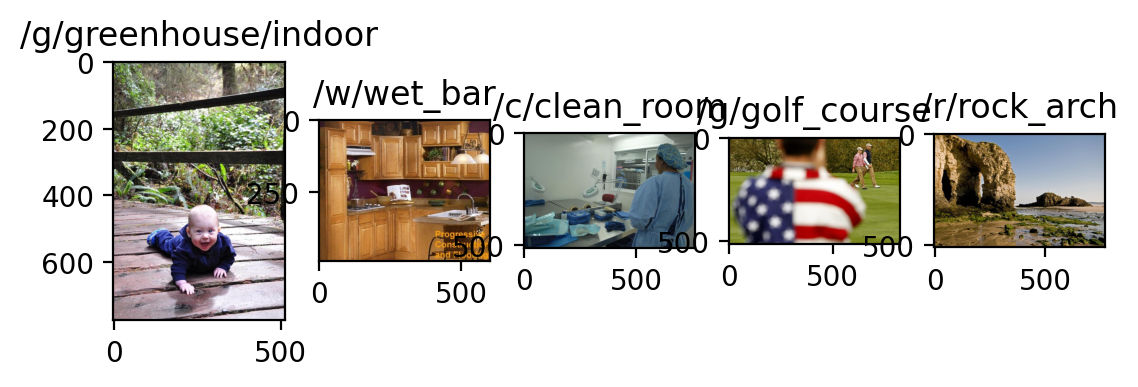

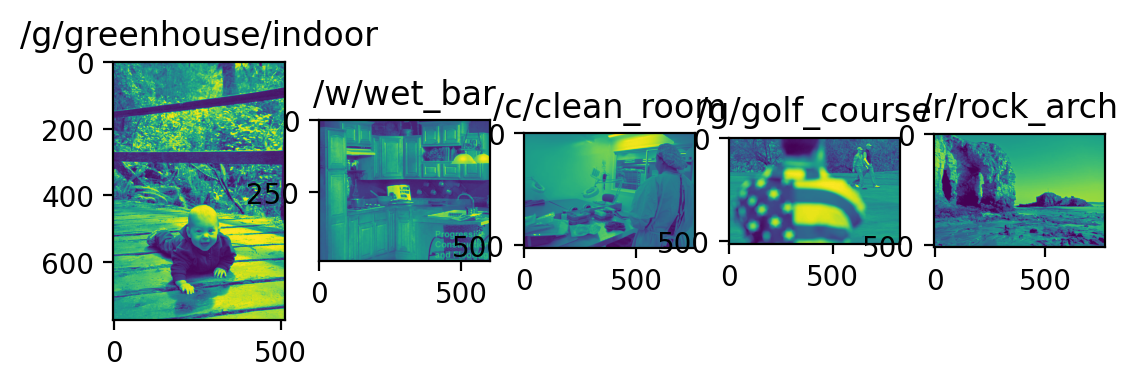

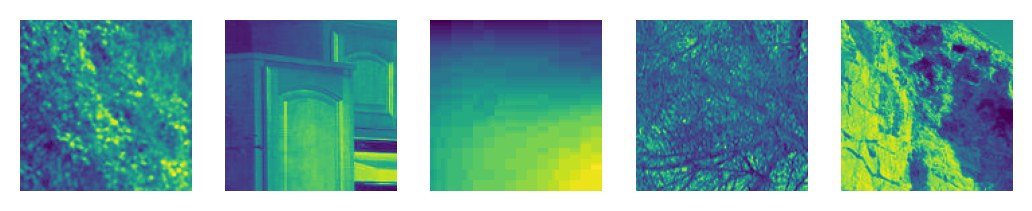

In [2]:
#some settings for the dataset
p65folder = '/home/vasha/phaseanalysis/images/places365/'
imfolder = p65folder+'val_large/'
imname = 'Places365_val_'
crop_size = (512,512)

#metadata
colnames = ['filename','category_ID']
df_fname_cid = pd.read_table(p65folder+'places365_val.txt',sep=' ',header=None,names=colnames)
colnames = ['category','category_ID']
df_cat_cid = pd.read_table(p65folder+'categories_places365.txt',sep=' ',header=None,names=colnames)
df_cat_lab = pd.read_csv(p65folder+'SceneHierarchy_Places365.csv', header=1)
df_cat_lab = df_cat_lab.iloc[:, 0:4] #don't need more specific than indoor/outdoor manmade/natural
df = pd.concat([df_cat_cid, df_cat_lab.iloc[:,1:]], axis=1)
df = pd.merge(df_fname_cid, df, on=['category_ID']).sort_values('filename')

#plt.figure(figsize=(15,3))
nims = 100
cropsize = 128
#keep list
imlist = []
imlumlist = []
imlumcroplist = []
catlist = []

#show only a few
nims_show = 5


for imn in range(nims):
    imn = imn+1
    testim_fname = imname+str(imn).zfill(8)+'.jpg'
    testim = imr.readin_im(testim_fname, imfolder)
    testim_cat = df.loc[df['filename'] == testim_fname,'category'].item()
    imlist.append(testim)
    testimlum = lum.calc_lum_img(testim)
    imlumlist.append(testimlum)
    imlumcroplist.append(testimlum[:cropsize,:cropsize])
    catlist.append(testim_cat)
    #print(testim_cat)
    if(imn <= nims_show):
        plt.subplot(1,nims_show,imn)
        plt.imshow(testim)
        plt.title(testim_cat)
plt.show()

#show lum imgs
for imn in range(nims_show):
    plt.subplot(1,nims_show,imn+1) 
    plt.imshow(imlumlist[imn])
    plt.title(catlist[imn])
plt.show()

#show lum crop imgs
for imn in range(nims_show):
    plt.subplot(1,nims_show,imn+1)
    plt.imshow(imlumcroplist[imn])
    plt.axis('off')
plt.show()

## Create Spatial Steerable Pyramid
using pyrtools toolbox

4


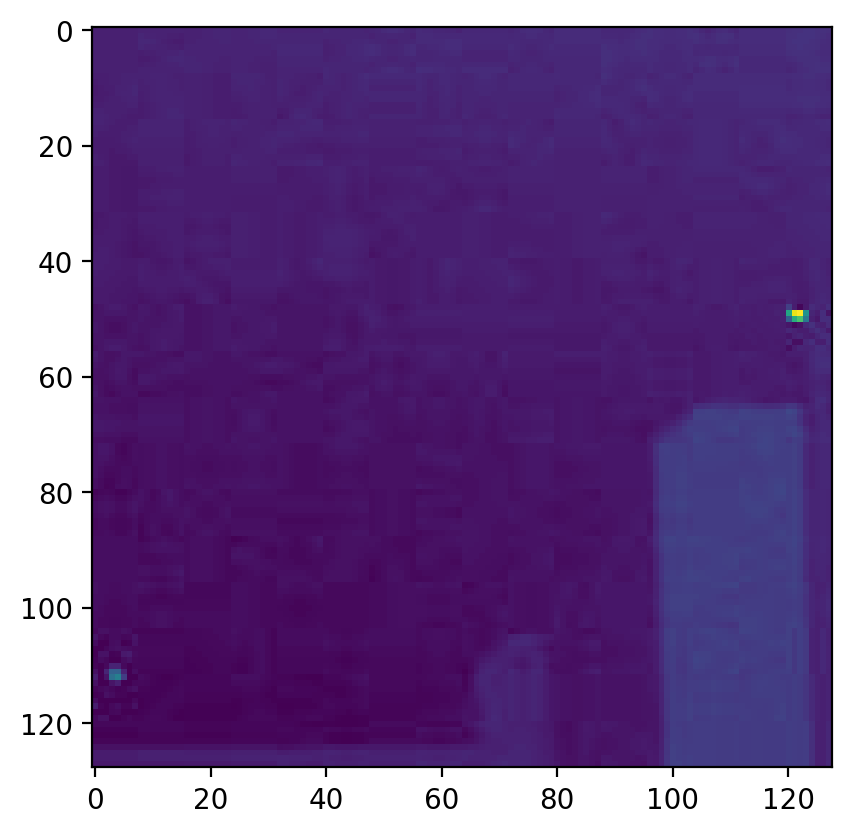

In [3]:
num_orientations=4 
pyrlist = []

for img in imlumcroplist:
    img_pyr = pt.pyramids.SteerablePyramidFreq(img, order=num_orientations-1, is_complex=True) #number of orientations is defined as order+1 in steerable pyramid source code
    pyrlist.append(img_pyr)

pyr_height = int((len(img_pyr.pyr_size)-2)/(num_orientations+1))
print(pyr_height)
plt.imshow(img)
plt.show()

### View Subband Mask

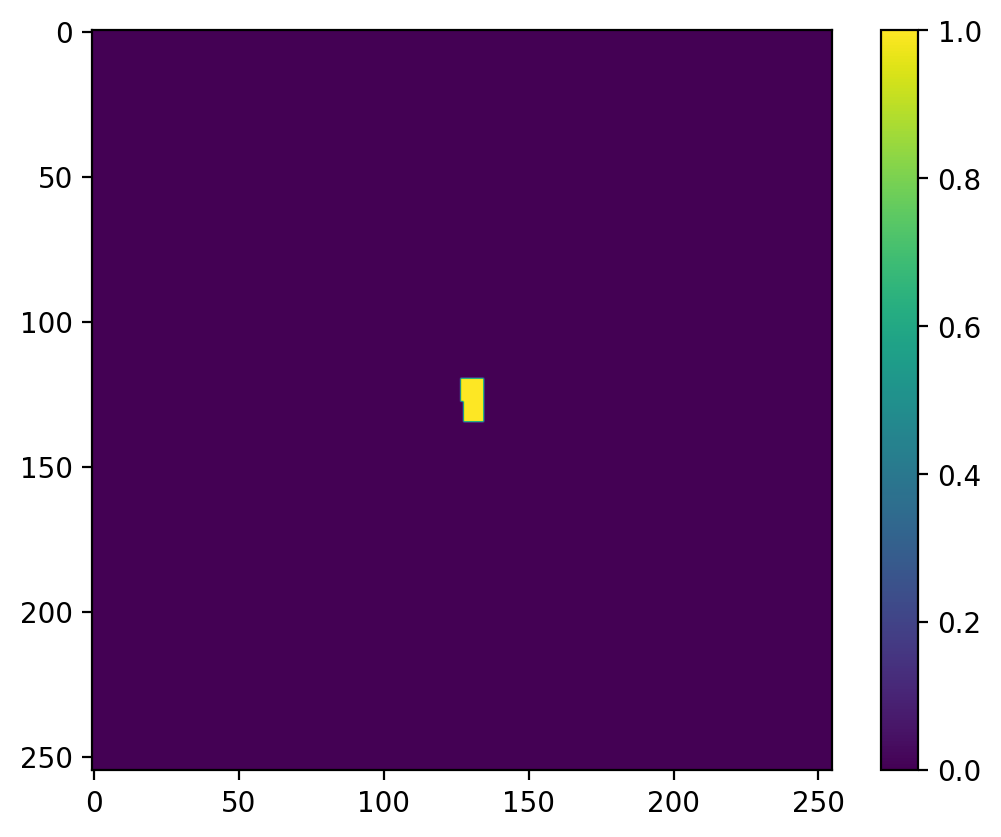

In [4]:
m=15

subband1 = np.real(img_pyr.pyr_coeffs[(0,2)])
subband2 = np.real(img_pyr.pyr_coeffs[(0,3)])
#plt.imshow(subband)
#plt.show()
acorr = scp.signal.correlate2d(subband1,subband2)
#acorr = acorr[3:-3,3:-3]
#crop half
#make crop mask
center_idx = (acorr.shape[0]-1)//2 #minus 1 because zero indexed
acorr_mask = np.zeros_like(acorr)
#acorr_mask[center_idx,center_idx] = 1 #want center part (explicitly)
acorr_mask[center_idx-(m-1)//2:center_idx+(m-1)//2+1:, #keep center plus half on right side
           center_idx:center_idx+(m-1)//2+1] = 1
acorr_mask[center_idx+1:center_idx+(m+1)//2, #remove duplicates in center column by removing bottom half
           center_idx] = 0
                   
plt.imshow(acorr_mask)
plt.colorbar()
plt.show()

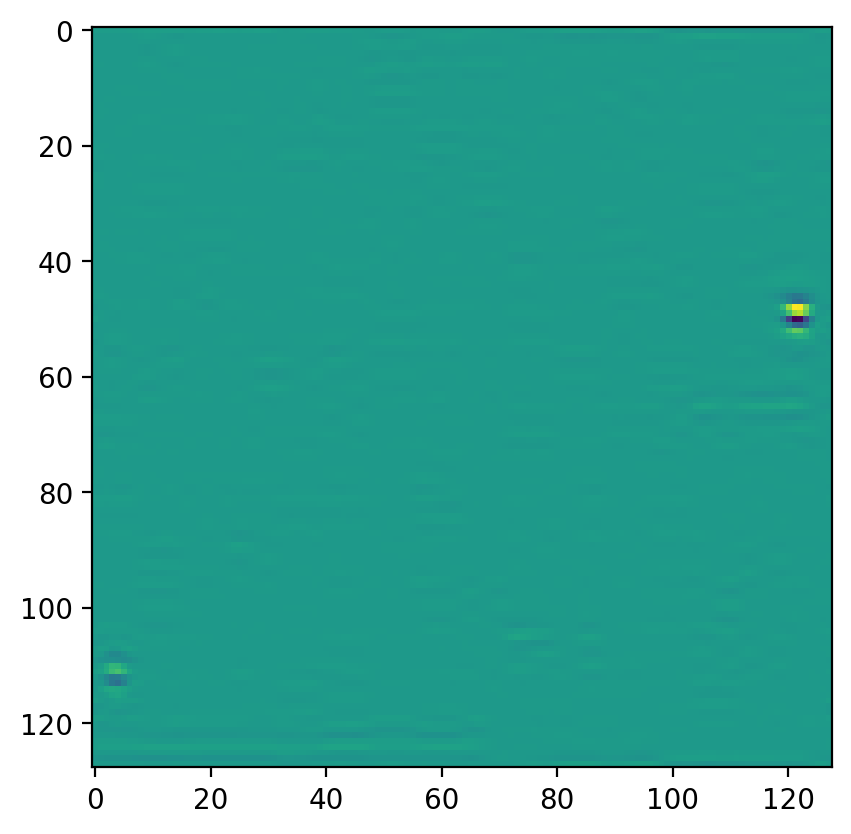

In [5]:
plt.imshow(subband1)
plt.show()

## Examplar Images

In [6]:
imp.reload(ss)

<module 'utils.stat_sets' from '/home/vasha/video_filtering/utils/stat_sets.py'>

In [7]:
#example set of statistics for a single image patch
imnums = [3,10,30,50,80]
imnums = [i+1 for i in imnums]
print(imnums)
import time
t = time.time()
statsdicts = [ss.get_stats_1999(pyrlist[imnum],imlumcroplist[imnum], pyr_height, num_orientations) for imnum in imnums] 
elapsed = time.time()-t
print(f'Elapsed time: {elapsed} seconds')

[4, 11, 31, 51, 81]
400 Real Auto Corr Stats
400 Magnitude Auto Corr Stats
24 Cross Orient Cross Scale Stats
60 Cross Orient Cross Scale Stats
400 Real Auto Corr Stats
400 Magnitude Auto Corr Stats
24 Cross Orient Cross Scale Stats
60 Cross Orient Cross Scale Stats
400 Real Auto Corr Stats
400 Magnitude Auto Corr Stats
24 Cross Orient Cross Scale Stats
60 Cross Orient Cross Scale Stats
400 Real Auto Corr Stats
400 Magnitude Auto Corr Stats
24 Cross Orient Cross Scale Stats
60 Cross Orient Cross Scale Stats
400 Real Auto Corr Stats
400 Magnitude Auto Corr Stats
24 Cross Orient Cross Scale Stats
60 Cross Orient Cross Scale Stats
Elapsed time: 67.13543486595154 seconds


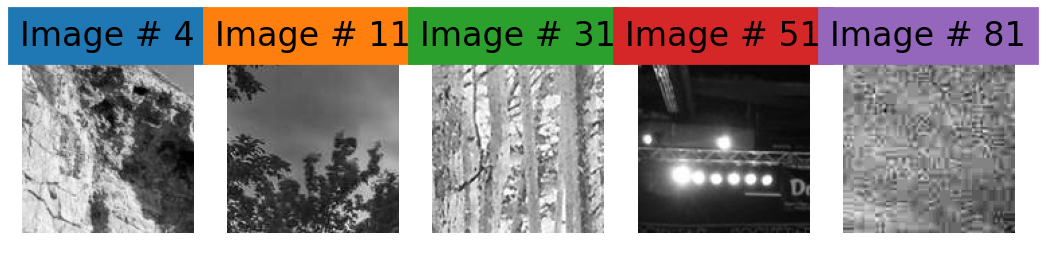

In [8]:
for i in range(len(imnums)):
    plotcolor = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    plt.subplot(1,len(imnums),i+1)
    plt.imshow(imlumcroplist[imnums[i]],cmap='gray')
    #print(plotcolor)
    plt.axis('off')
    plt.title(f'Image # {imnums[i]}',backgroundcolor=plotcolor)
plt.show()

In [10]:
statsdicts[0].keys()

dict_keys(['pixel_mean', 'pixel_var', 'pixel_skew', 'pixel_kurt', 'pixel_min', 'pixel_max', 'pyr_raw_mean_low', 'pyr_raw_var_low', 'pyr_raw_min_low', 'pyr_raw_max_low', 'pyr_raw_mean_high', 'pyr_raw_var_high', 'pyr_raw_min_high', 'pyr_raw_max_high', 'pyr_real_autocorrs', 'pyr_mag_autocorr', 'pyr_mag_scale_cross_orient', 'pyr_mag_cross_scale_cross_orient'])

### Pixel Stats

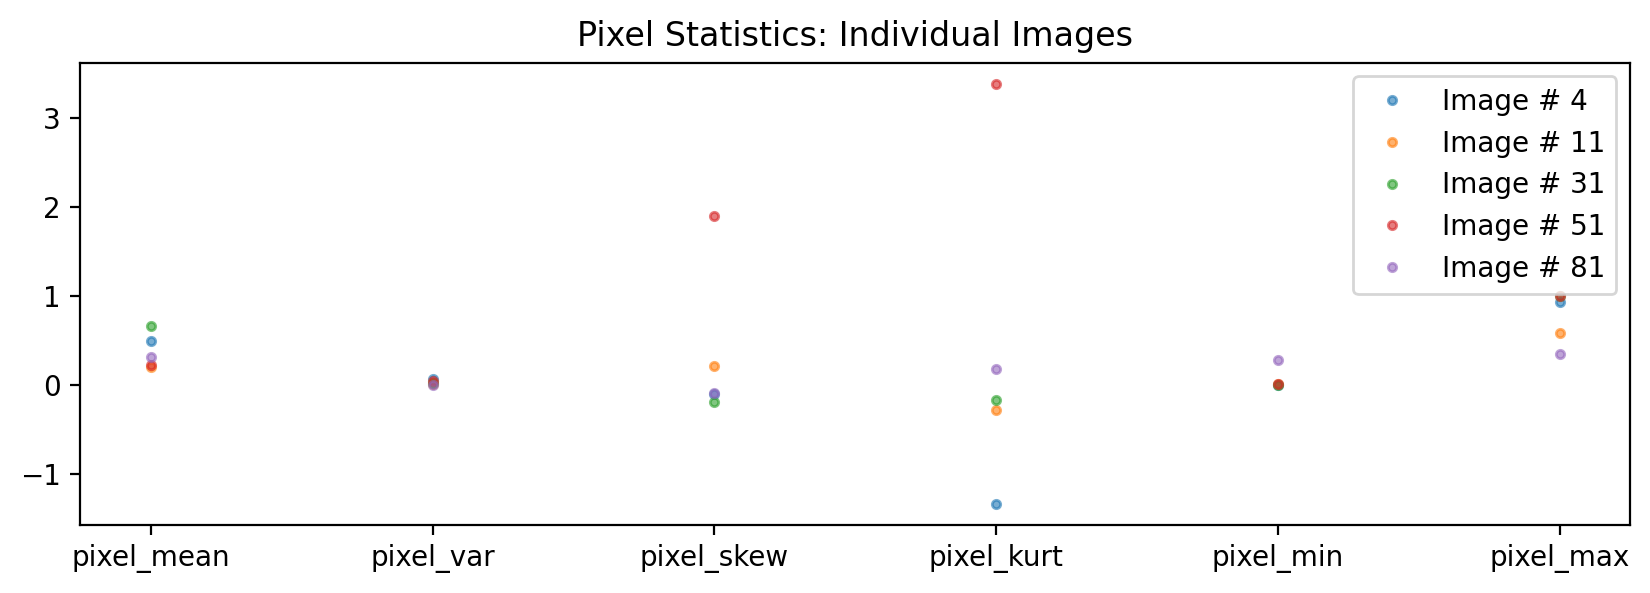

In [11]:
statsnames = ['pixel_mean', 'pixel_var', 'pixel_skew', 'pixel_kurt', 'pixel_min','pixel_max']

fig, ax = plt.subplots(figsize=(10,3))
for i, statsdict in enumerate(statsdicts):  
    statslist = [statsdict[st] for st in statsnames]
    imnum = imnums[i]
    ax.plot(statsnames, statslist,'.',label=f'Image # {imnums[i]}',alpha=0.6)

#ax.set_xticklabels(statsnames, rotation = 90)
plt.title('Pixel Statistics: Individual Images')
ax.legend()
plt.show()
        

### Pyramid Stats

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


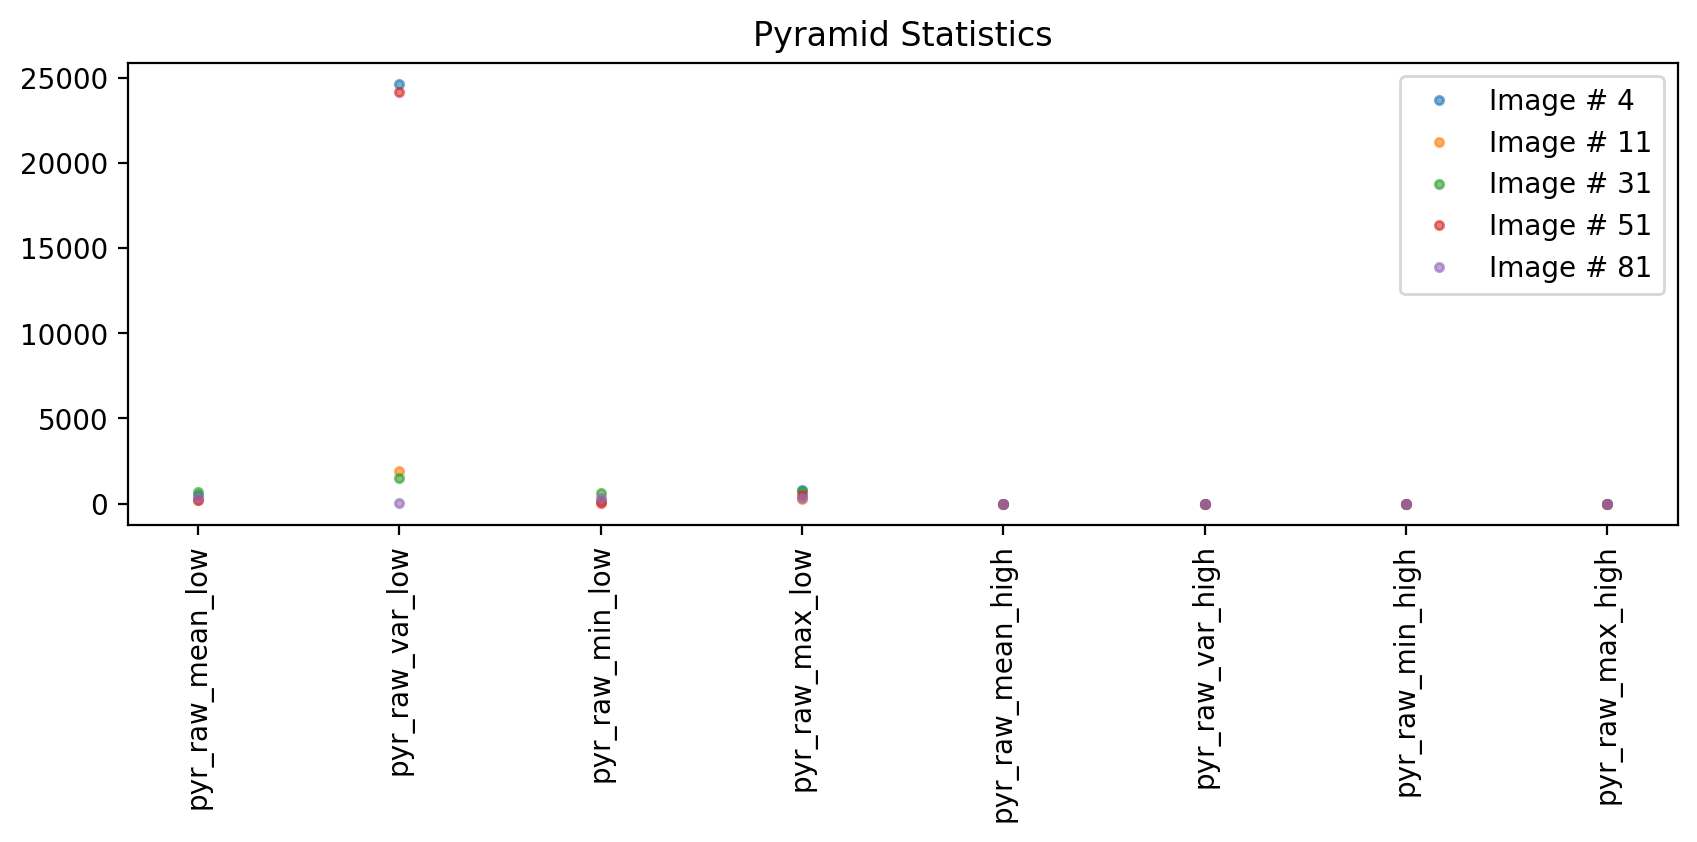

In [12]:
statsnames = ['pyr_raw_mean_low', 'pyr_raw_var_low', 'pyr_raw_min_low', 'pyr_raw_max_low',
              'pyr_raw_mean_high', 'pyr_raw_var_high', 'pyr_raw_min_high', 'pyr_raw_max_high']

fig, ax = plt.subplots(figsize=(10,3))
for i, statsdict in enumerate(statsdicts):  
    statslist = [statsdict[st] for st in statsnames]
    imnum = imnums[i]
    ax.plot(statsnames, statslist,'.',label=f'Image # {imnums[i]}',alpha=0.6)

ax.set_xticklabels(statsnames, rotation = 90)
ax.legend()
plt.title('Pyramid Statistics')
plt.show()
        

### Pyramid Auto and Cross Correlations

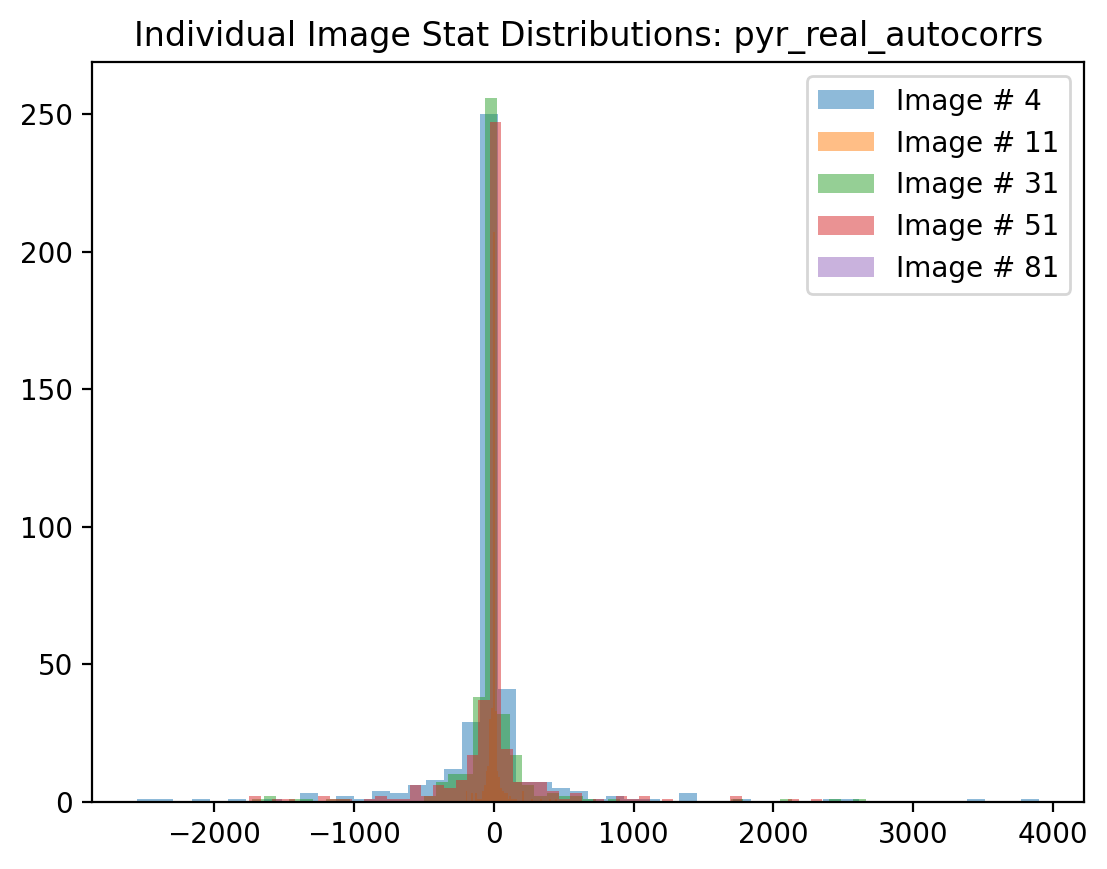

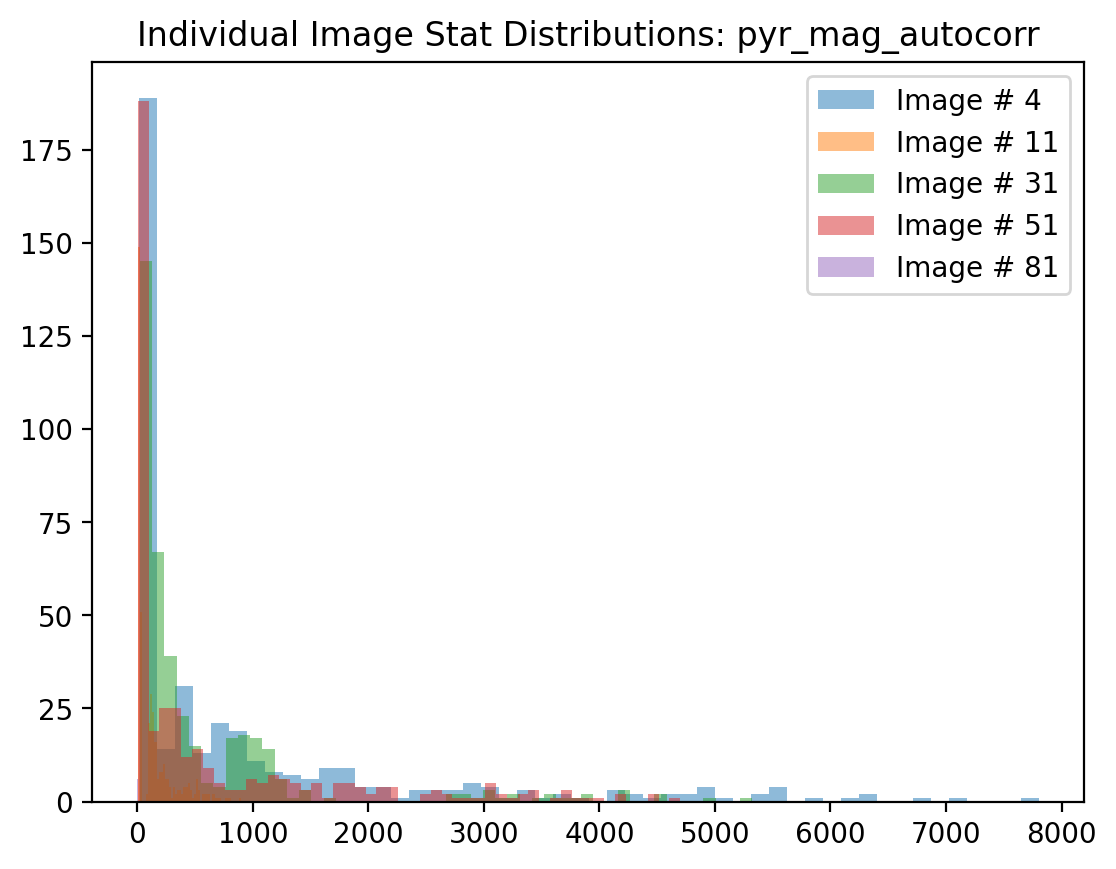

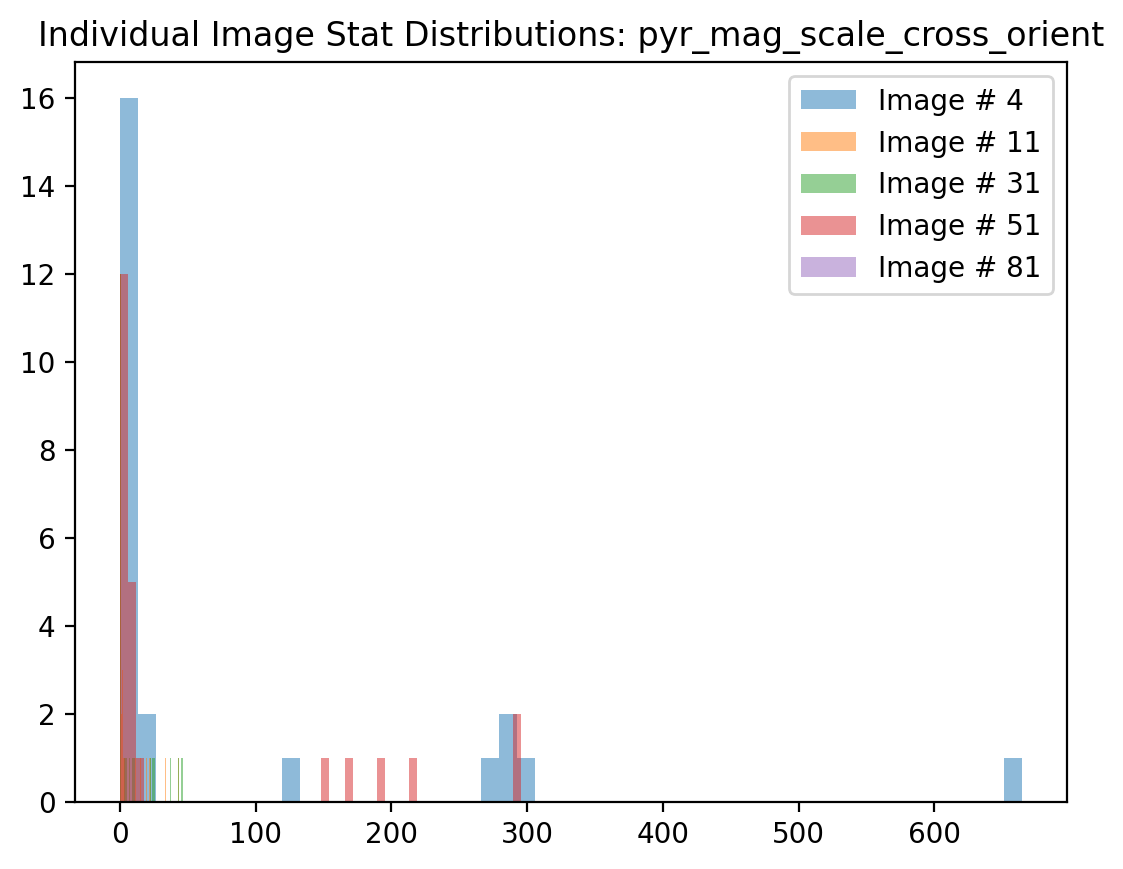

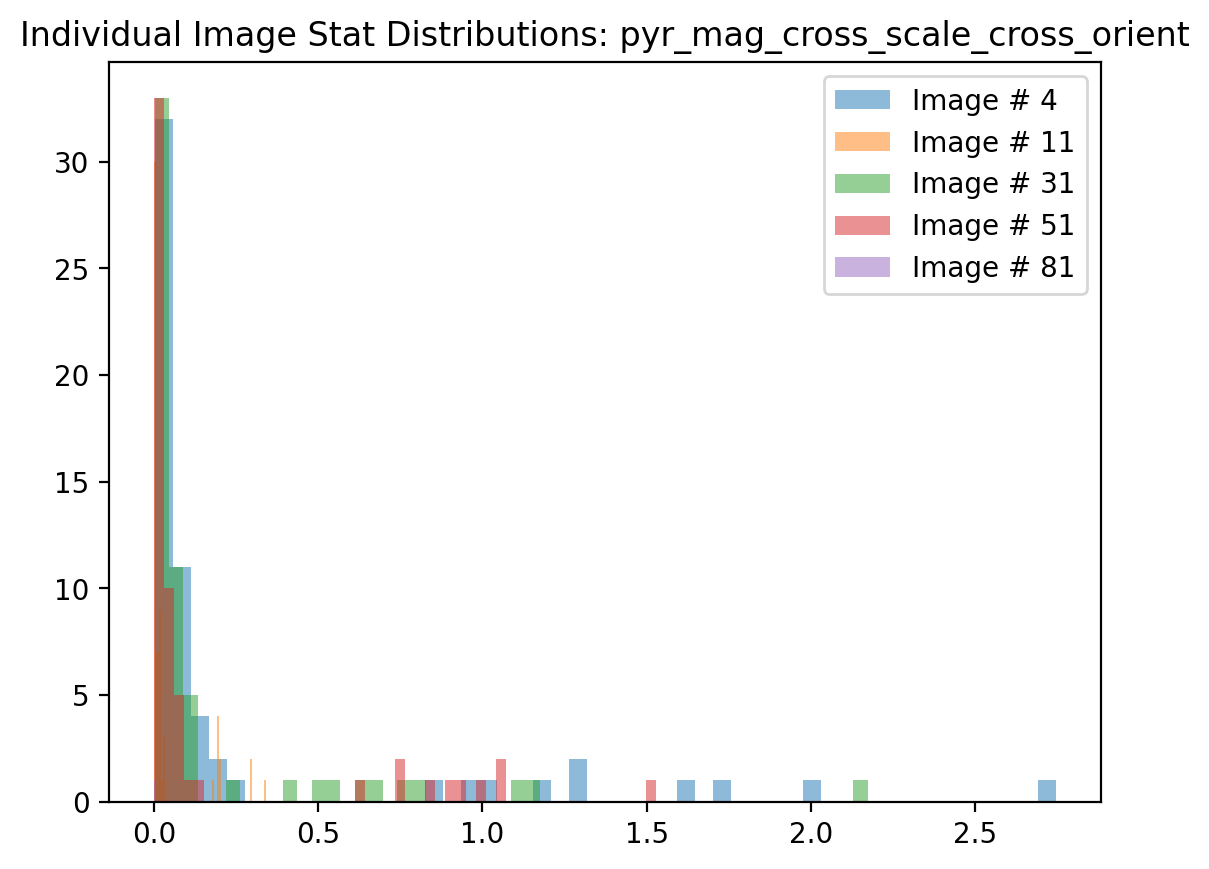

In [13]:
for stat_category in ['pyr_real_autocorrs','pyr_mag_autocorr','pyr_mag_scale_cross_orient','pyr_mag_cross_scale_cross_orient']:
    for i, statsdict in enumerate(statsdicts):
        stats = statsdict[stat_category]
        plt.hist(stats,bins=50,label=f'Image # {imnums[i]}', alpha=0.5);
    plt.title(f'Individual Image Stat Distributions: {stat_category}')
    plt.legend()
    plt.show()